# Image dataset
The super resolution algorithm was trained on the PMID2019 algorithm: a collection of bright field microscopy images.

In [936]:
#loading of the packages
import numpy as np
from scipy import ndimage
from scipy import signal
import skimage.io
from skimage import morphology
from skimage import filters
from skimage import transform
from skimage import draw
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import os
import random
import pandas as pd
import sys
import time
import pickle
import importlib
import cv2
import pywt
import matplotlib.patches as patches
#custom packages
function_dir = os.path.join(os.pardir, 'Functions')
sys.path.append(function_dir)

import segmentation as seg
importlib.reload(seg) #to make sure the last version of seg is used


<module 'segmentation' from '..\\Functions\\segmentation.py'>

In [937]:
#loading of the images

data_base_path = os.path.join(os.pardir, 'Datasets')
#data_folder = os.path.join('Aquascope','raw_only')
data_folder = os.path.join('Plancktoscope','20211101_pond2_1','20211101_pond2_1_113')
data_path = os.path.join(data_base_path, data_folder)


In [938]:
os.listdir(data_path)

['04_17_37_937534.jpg',
 '04_17_40_981181.jpg',
 '04_17_43_924601.jpg',
 '04_17_47_578648.jpg',
 '04_17_50_609171.jpg',
 '04_17_53_505973.jpg',
 '04_17_56_423084.jpg',
 '04_17_59_572294.jpg',
 '04_18_03_054565.jpg',
 '04_18_05_868647.jpg',
 '04_18_08_826683.jpg',
 '04_18_11_794977.jpg',
 '04_18_15_331485.jpg',
 '04_18_18_854680.jpg',
 '04_18_21_773968.jpg',
 '04_18_24_664746.jpg',
 '04_18_27_610190.jpg',
 '04_18_31_251795.jpg',
 '04_18_34_256107.jpg',
 '04_18_37_237011.jpg',
 'integrity.check',
 'metadata.json']

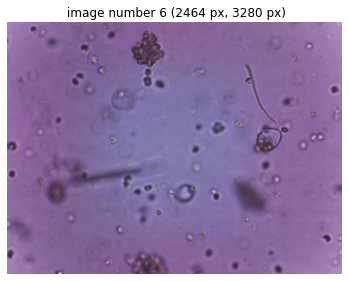

In [944]:
#test the validity of one random img
i = 6#change value to change img
img = skimage.io.imread(os.path.join(data_path, os.listdir(data_path)[i]))
im_h, im_w, im_channel = img.shape

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(img, cmap='gray')
ax.set_title(' image number '+str(i)+' ({} px, {} px)'.format(im_h, im_w))
ax.axis('off')
plt.show()


As most images contain mainly white parts, the first step is to select ROI. Here is the principle described for one image:

In [945]:
threshold = 0.1
min_area  = 2000 #minimal area to filter out noise (in pixels)

get the background by taking the mean of the dataset

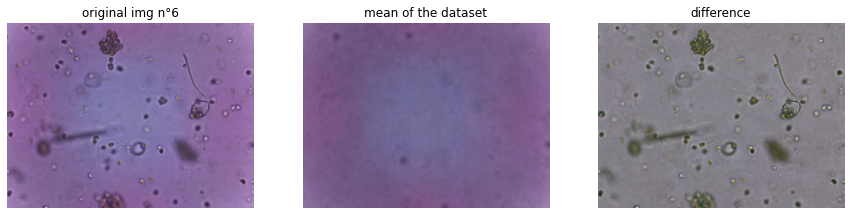

In [946]:
sum_img = np.zeros(img.shape)
for file in os.listdir(data_path):
    try:
        img_k = skimage.io.imread(os.path.join(data_path,file))
    except:
        continue
    sum_img = img_k+sum_img
mean_img = sum_img/len(os.listdir(data_path))


fig, ax = plt.subplots(1, 3, figsize=(15, 18))

ax[0].imshow(img)
ax[0].set_title('original img n°'+str(i))
ax[0].axis('off')
ax[1].imshow(mean_img.astype(int))
ax[1].set_title('mean of the dataset')
ax[1].axis('off')
diff = img-mean_img
diff_rescale = (diff-np.min(diff))/(np.max(diff)-np.min(diff))
ax[2].imshow(diff_rescale)
ax[2].axis('off')
ax[2].set_title('difference')
plt.show()

In [962]:
shrink_factor = 2
threshold = 0.5
dil_size = 6
min_area = 10
sigma = 5

the preprocessing took: 
 - 0.02121519998763688s to shrink the image
 - 0.04639450000831857s to process the high pass filter
 - 0.06450609999592416s to binarize it
 - 0.1863561999925878s to close it
 - 0.009827800007769838s to label it
 - 0.026714100007666275s to filter it 
 ----TOTAL: 0.3550138999999035


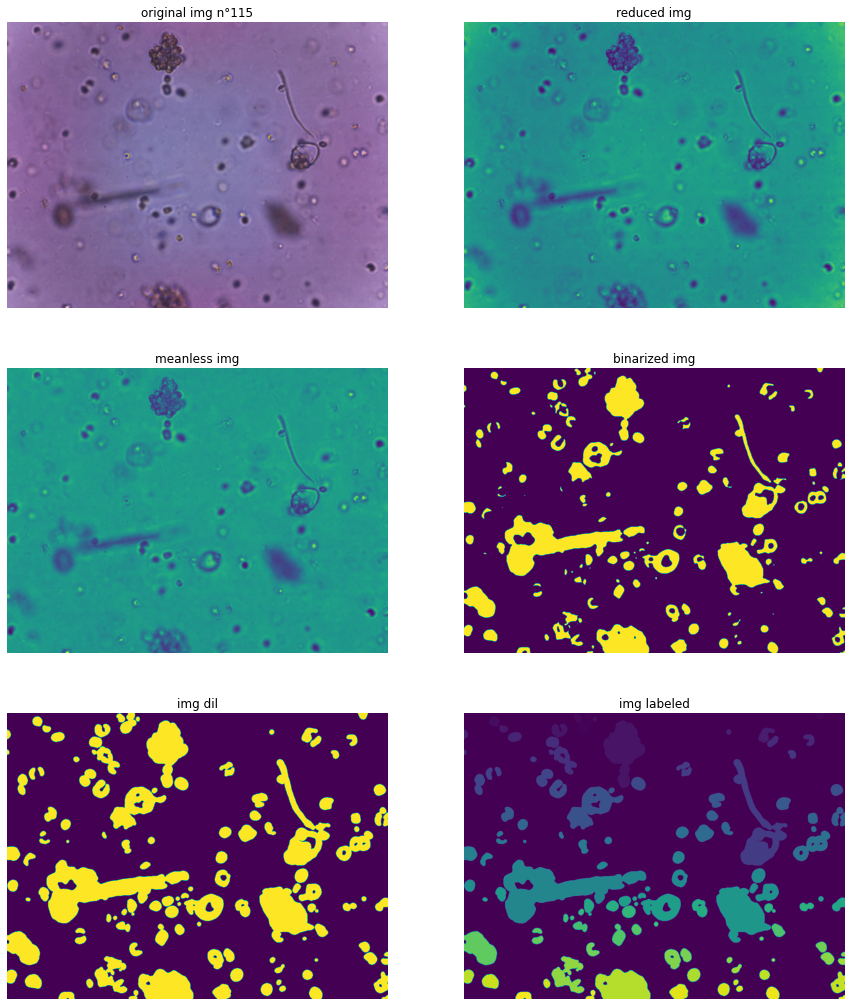

In [963]:
t0 = time.perf_counter()
#shrink the image to fasten the calculations, and turn it grey
img_small = np.sum(img[0::shrink_factor,0::shrink_factor],axis = 2)
t00 = time.perf_counter()
#substract the mean and renormalize:
diff = img_small-np.sum(mean_img[0::shrink_factor,0::shrink_factor],axis = 2)
diffn = (diff-np.min(diff))/(np.max(diff)-np.min(diff))
t1 = time.perf_counter()

#binarize
img_smooth = filters.gaussian(diffn,sigma)
img_bin = img_smooth < threshold

t3 = time.perf_counter()

#morphological op
img_op = morphology.binary_opening(img_bin)
img_op = morphology.binary_opening(img_op)
img_dil = morphology.binary_dilation(img_op,selem = morphology.disk(dil_size))
t4 = time.perf_counter()

#watershed
img_label, n_ROI = ndimage.label(img_dil.astype(int))
t5 = time.perf_counter()

#filter out the background
ids, count = np.unique(img_label,return_counts = True)
new_ids = np.zeros((ids[-1]+1), dtype = int)
j = 0
for i,c in zip(ids,count):
    if c != np.max(count):
            j = j+1
            new_ids[i]=j
#apply the filter:
if ids[-1]>1:
    img_filtered = new_ids[img_label[:,:]]
else:
    img_filtered = np.zeros(np.shape(img_label),dtype = int)
t6 = time.perf_counter()            


#print performances:
print('the preprocessing took: \n - '
     +str(t00-t0)+'s to shrink the image\n - '
     +str(t1-t00)+'s to process the high pass filter\n - '
     +str(t3-t1)+'s to binarize it\n - '
     +str(t4-t3)+'s to close it\n - '
     +str(t5-t4)+'s to label it\n - '
     +str(t6-t5)+'s to filter it \n ----TOTAL: '+str(t6-t0))

#plot
fig, ax = plt.subplots(3, 2, figsize=(15, 18))

ax[0,0].imshow(img)
ax[0,0].set_title('original img n°'+str(i))
ax[0,0].axis('off')

ax[0,1].set_title('reduced img')
ax[0,1].imshow(img_small)
ax[0,1].axis('off')

ax[1,0].set_title('meanless img')
ax[1,0].imshow(diffn)
ax[1,0].axis('off')

ax[1,1].set_title('binarized img')
ax[1,1].imshow(img_bin)
ax[1,1].axis('off')

ax[2,0].set_title('img dil')
ax[2,0].imshow(img_dil)
ax[2,0].axis('off')

ax[2,1].set_title('img labeled')
ax[2,1].imshow(img_filtered)
ax[2,1].axis('off')
plt.show()


In [968]:
dil_size_sharp = 15
threshold_sharp = 0.03

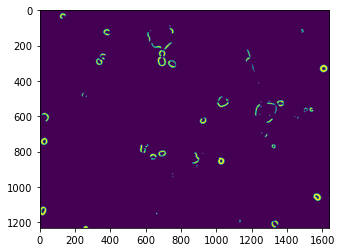

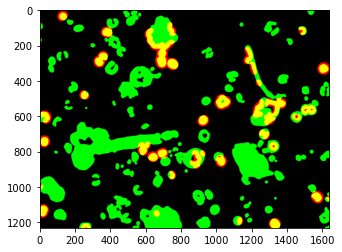

In [970]:
f1 = filters.sobel(img_smooth)
sharp = f1>threshold_sharp
sharp_dil = morphology.binary_dilation(sharp,selem = morphology.disk(dil_size_sharp))

plt.imshow(sharp)
plt.show()

img_compound = np.zeros((img_smooth.shape[0],img_smooth.shape[1],3))
img_compound[:,:,0]=sharp_dil
img_compound[:,:,1]=img_dil
#img_compound[:,:,2]=np.logical_or(f1>0.03,img_dil)


plt.imshow(img_compound)
plt.show()

In [954]:
img_border = filters.sobel(img_small)
t1 = time.perf_counter()
threshold =0.3
#normalize the sobel filtered images
b_min = np.min(img_border)
b_max = np.max(img_border)
diff = b_max-b_min
img_bordern = (img_border-b_min)/diff
img_to_filter = np.copy(img_bordern)


img_bin_focus = img_bordern > threshold
img_close_focus = morphology.binary_dilation(img_bin_focus,selem = morphology.disk(dil_size))
np.putmask(img_to_filter, img_close_focus, 0)
img_bin_out = (img_to_filter > threshold/2)
img_close_out = morphology.binary_dilation(img_bin_out,selem = morphology.disk(dil_size))
np.putmask(img_to_filter, img_close_out, 0)
img_bin_veryout = (img_to_filter > threshold/4)
img_close_veryout = morphology.binary_dilation(img_bin_veryout,selem = morphology.disk(dil_size))


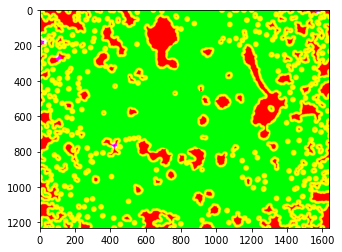

In [955]:
chanimg = np.zeros((img_close_focus.shape[0],img_close_focus.shape[1],3))
chanimg[:,:,0]=img_close_focus
chanimg[:,:,1]=img_close_out
chanimg[:,:,2]=img_close_veryout
plt.imshow(chanimg)

As the method above is not quite resilient, each ROI is treated separately to find how well it is focused

Once the images are correctly labeled, one can segment the wanted ROI and store them in a list

In [956]:
np.unique(img_filtered)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69])

In [957]:
margin = 5
ROI_list = []
c_list =[]
for i in range(1,j+1):
    x,y = np.where(img_filtered ==i)
    xmin = 2*max(np.min(x)-margin,0)
    ymin = 2*max(np.min(y)-margin,0)
    xmax = 2*min(np.max(x)+margin,im_h//2)
    ymax = 2*min(np.max(y)+margin,im_w//2)
    c_list.append((xmin,ymin))
    ROI_list.append(img[xmin:xmax,ymin:ymax])

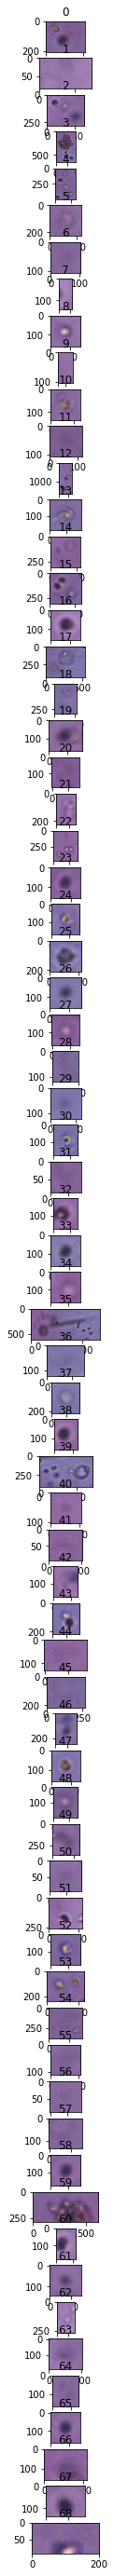

In [958]:
fig, ax = plt.subplots(len(ROI_list), figsize=(15, 50))
if len(ROI_list)>1:
    for i,ROI in enumerate(ROI_list): 
        ax[i].imshow(ROI)
        ax[i].set_title(str(i))
else:
    ax.imshow(ROI_list[0])

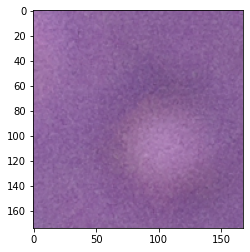

In [959]:
i = 34
ROI = ROI_list[i]
plt.imshow(ROI)

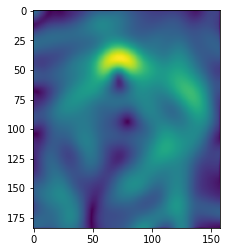

0.013663426378034287


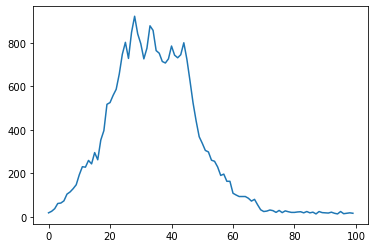

0.40765917395756457


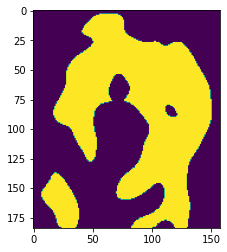

In [852]:
#normalize the ROI, then filter it with a sobel kernel
ROIg = np.mean(ROI,axis=2)
ROIn = (ROIg-np.min(ROIg))/(np.max(ROIg)-np.min(ROIg))
gaussROI = filters.gaussian(ROIn,10)
sobelROI = filters.sobel(gaussROI)#ndimage.gaussian_laplace(ROIn,5)
hist,b = np.histogram(sobelROI,100)
plt.imshow(sobelROI)
plt.show()
plt.plot(hist)
print(b[-2])
plt.show()
p50,p99 = np.percentile(sobelROI,[50,99])
print(p50/p99)
plt.imshow(sobelROI>p)

In [853]:
cslice

[slice(None, 4, None),
 {'ad': slice(4, 8, None),
  'da': slice(8, 12, None),
  'dd': slice(12, 16, None)},
 {'ad': slice(16, 28, None),
  'da': slice(28, 40, None),
  'dd': slice(40, 52, None)},
 {'ad': slice(52, 94, None),
  'da': slice(94, 136, None),
  'dd': slice(136, 178, None)},
 {'ad': slice(178, 346, None),
  'da': slice(346, 514, None),
  'dd': slice(514, 682, None)},
 {'ad': slice(682, 1330, None),
  'da': slice(1330, 1978, None),
  'dd': slice(1978, 2626, None)},
 {'ad': slice(2626, 5164, None),
  'da': slice(5164, 7702, None),
  'dd': slice(7702, 10240, None)},
 {'ad': slice(10240, 20298, None),
  'da': slice(20298, 30356, None),
  'dd': slice(30356, 40414, None)},
 {'ad': slice(40414, 80646, None),
  'da': slice(80646, 120878, None),
  'dd': slice(120878, 161110, None)},
 {'ad': slice(161110, 321235, None),
  'da': slice(321235, 481360, None),
  'dd': slice(481360, 641485, None)},
 {'ad': slice(641485, 1281235, None),
  'da': slice(1281235, 1920985, None),
  'dd': slice(1

In [854]:
def wavelethisto(ROI,pad=0,normalize=True):
    ROIg = np.mean(ROI,axis=2)
    #ROIn = (ROIg-np.min(ROIg))/(np.max(ROIg)-np.min(ROIg))
    coeffs = pywt.wavedec2(ROIg, 'haar',level=None)
    coeffs1, cslice,cshape = pywt.ravel_coeffs(coeffs, axes=None)
    histo = []
    for slicedim in cslice:
        if isinstance(slicedim,dict):
            totdim = 0
            for direction in ('ad','dd','da'):
                totdim+= np.percentile(np.abs(coeffs1[slicedim[direction]]),99)
        #else:
            #totdim = np.max(np.abs(coeffs1[slicedim]))
            histo.append(totdim)
    #histo = [el/histo[0] for el in histo[1:]]
    
    if normalize:
        histo_n = [el/(2**(len(histo)-i)) for i,el in enumerate(histo)]
        histo = histo_n
    if pad > 0:
        hist_pad = np.ones(pad)*histo[0]
        hist_pad[-1:-len(histo)-1:-1]=histo[-1::-1]
        return hist_pad
    else:
        return histo

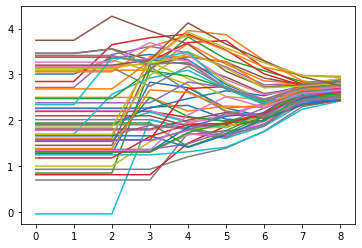

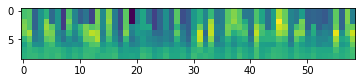

In [855]:
fig1 = plt.subplot()
#sample = [ROI_list[12],ROI_list[13],ROI_list[28],ROI_list[21]]
sample = ROI_list
pad = 13
hist_a = np.zeros(shape=(pad,len(sample)))
for i,ROI in enumerate(sample):
    hist = wavelethisto(ROI,pad = pad)
    fig1.plot(np.log(hist[4:]))
    hist_a[:,i]=np.log(hist)
    #fig1.legend([el for ])
plt.show()
plt.imshow(hist_a[4:,:])

On the image above, each ROI is represented in a column. The yellower the pixel the higher the coefficient is. If a ROI has a lot of high 

In [856]:
def takeSecond(elem,num_comp=0):
    return elem[1][num_comp]
tup = sorted(enumerate(hist_a.T),key=takeSecond)
idx = [el[0] for el in tup]

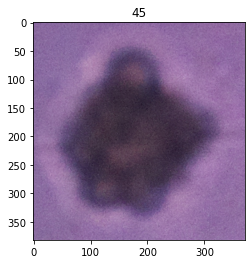

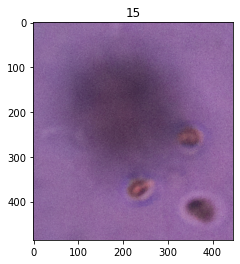

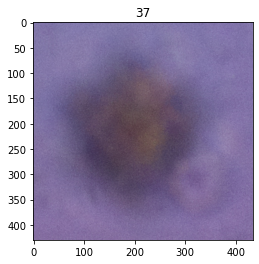

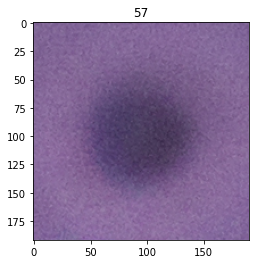

In [857]:
for i in idx[-1:-5:-1]:
    plt.imshow(ROI_list[i])
    plt.title(i)
    plt.show()

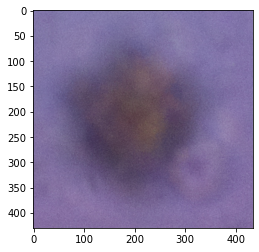

In [858]:
i = 37
ROI = ROI_list[i]
plt.imshow(ROI)
#plt.imshow(img_filtered==i+1)

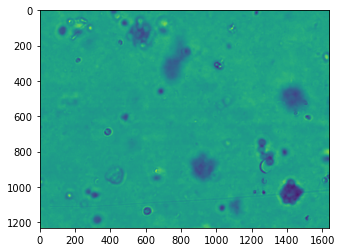

In [859]:
plt.imshow(diffn)

(0, 2382)
(98, 132, 3)


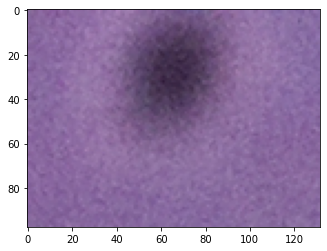

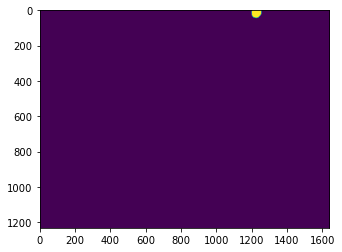

In [860]:
print(c_list[1])
print(ROI_list[1].shape)
plt.imshow(ROI_list[1])
plt.show()
plt.imshow(img_filtered==2)
plt.show()


In [876]:
shape[:2]

(150, 134)

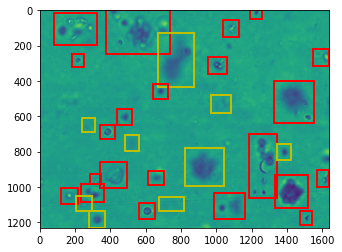

In [878]:
fig, ax = plt.subplots()
ax.imshow(diffn)
for i,ROI in enumerate(ROI_list):
    shape = ROI.shape
    if hist_a[-1,i]<hist_a[-4,i]:
        rect = patches.Rectangle((c_list[i][1]//2,c_list[i][0]//2), shape[1]//2, shape[0]//2, linewidth=2, edgecolor='r', facecolor='none')
    else:
        if np.min(shape[:2])>150:
            rect = patches.Rectangle((c_list[i][1]//2,c_list[i][0]//2), shape[1]//2, shape[0]//2, linewidth=2, edgecolor='y', facecolor='none')
    ax.add_patch(rect)

        
plt.show()

In [862]:
ROI = ROI_list[0]

In [839]:
ROIg = np.mean(ROI,axis=2)
ROIn = (ROIg-np.min(ROIg))/(np.max(ROIg)-np.min(ROIg))
coeffs = pywt.wavedec2(ROIn, 'haar')
coeffs1, cslice,cshape = pywt.ravel_coeffs(coeffs, axes=None)

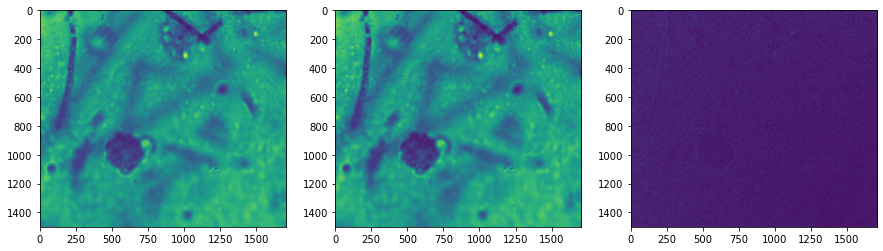

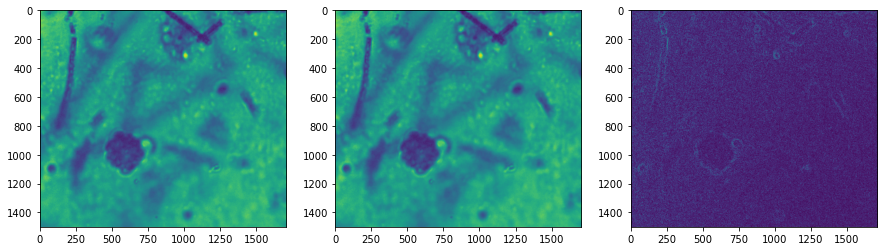

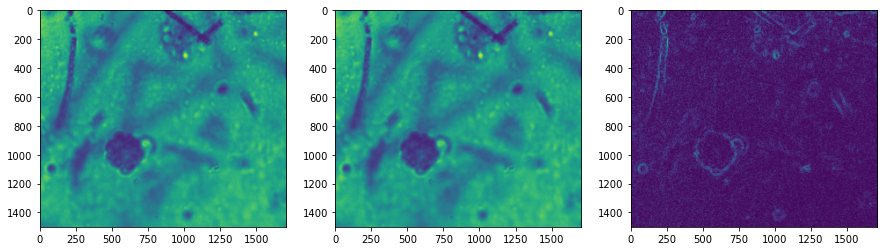

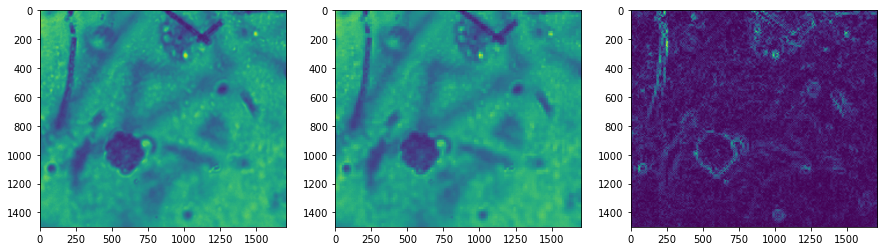

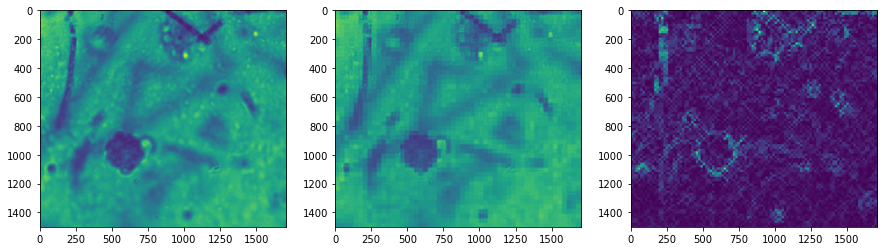

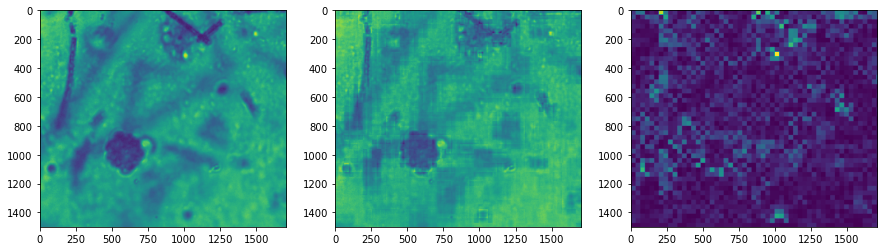

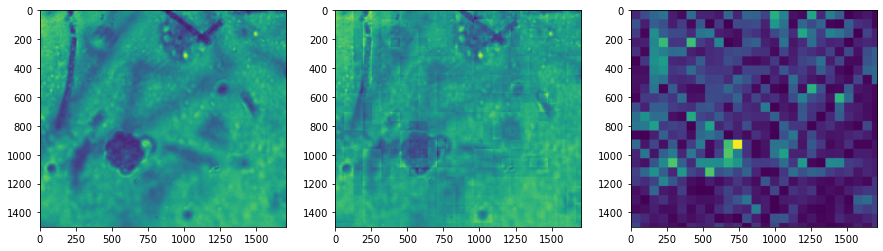

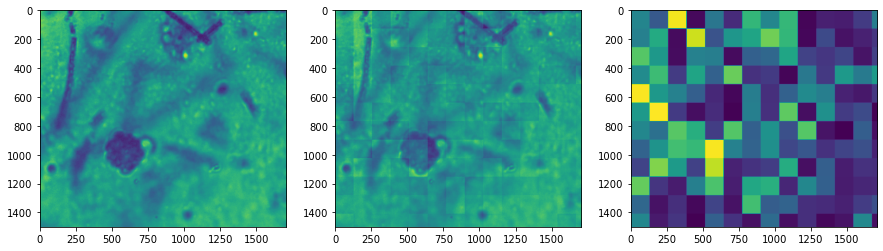

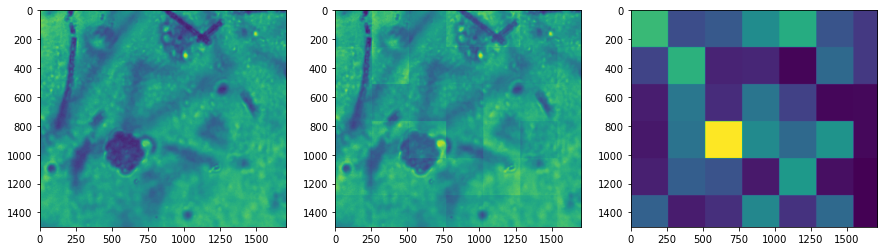

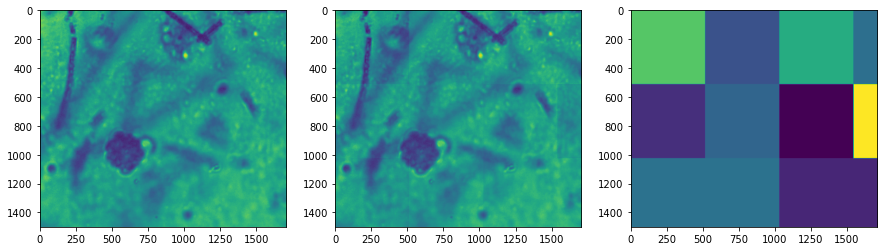

In [840]:
#build the image by removing a given coeff and comput the difference

for idx in cslice[-1:0:-1]:
        coeffs_new = np.copy(coeffs1)
        coeffs_new[idx['dd']] = 0
        coeffs_new[idx['ad']] = 0
        coeffs_new[idx['da']] = 0
        fig, ax = plt.subplots(1,3, figsize=(15, 5))
        img_rec = pywt.waverec2(pywt.unravel_coeffs(coeffs1,cslice,cshape,output_format='wavedec2'),'haar')
        img_filtered = pywt.waverec2(pywt.unravel_coeffs(coeffs_new,cslice,cshape,output_format='wavedec2'),'haar')
        img_diff = np.abs(img_rec-img_filtered)
        ax[0].imshow(img_rec)
        ax[1].imshow(img_filtered)
        ax[2].imshow(img_diff)
        plt.show()
        

In [601]:
coeffs[1]

(array([[ 3.58849826, -1.334375  ],
        [ 0.        ,  0.        ]]),
 array([[ 2.93142361,  0.        ],
        [-0.54027778,  0.        ]]),
 array([[-0.98077257,  0.        ],
        [ 0.        ,  0.        ]]))

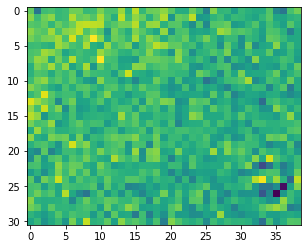

In [234]:
plt.imshow(np.sum(coeffs[5],axis=0))

In [235]:
#rec = pywt.idwt2((cA,(None,None,None)), 'haar')
rec = pywt.waverec2(coeffs, 'haar')

ValueError: Unexpected detail coefficient type: <class 'numpy.ndarray'>. Detail coefficients must be a 3-tuple of arrays as returned by wavedec2. If you are using pywt.array_to_coeffs or pywt.unravel_coeffs, please specify output_format='wavedec2'

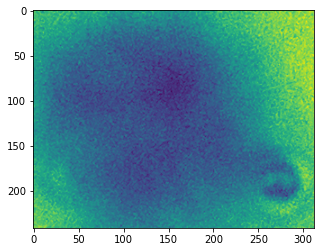

In [227]:
plt.imshow(rec)

The previously seen function have been integrated in segmentation.py file, allowing an easy reuse of them

In [53]:
i = 456 #change value to change img
img = skimage.io.imread(os.path.join(data_path, 'SPC-EAWAG-5P0X-1635411681512843-39918823952846-000019-002-1766-1510-52-52_rawcolor.jpeg'))
img_label = seg.label_img(img,dil_size = 4)
ROI_list = seg.segment(img, img_label)
fig, ax = plt.subplots(len(ROI_list), figsize=(15, 10))
if len(ROI_list)>1:
    for i,ROI in enumerate(ROI_list): 
        ax[i].imshow(ROI)
else:
    ax.imshow(ROI_list[0])

ValueError: Number of rows must be a positive integer, not 0

<Figure size 1080x720 with 0 Axes>

The preprocessing steps are used on all images:

In [55]:
ROI_list = []
n_max = 10000
for i,folder in enumerate(os.listdir(data_path)):
    if i%10 == 0:
        print(str(i)+'/'+str(len(os.listdir(data_path))),end='\r')
    img = skimage.io.imread(os.path.join(data_path, folder))
    img_label = seg.label_img(img, plot = False, th = 0.05, min_area = 100,shrink_factor = 3,dil_size = 4)
    #ROI_list+=seg.segment(img, img_label)
    ROI_list.append(img)

In [56]:
len(ROI_list)

251

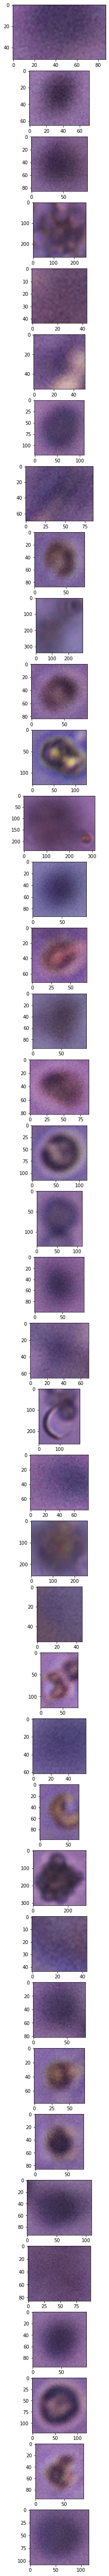

In [117]:
fig, ax = plt.subplots(len(ROI_list), figsize=(18, 100))
if len(ROI_list)>1:
    for i,ROI in enumerate(ROI_list): 
        ax[i].imshow(ROI)
else:
    ax.imshow(ROI_list[0])

The list of ROI is saved in order not to recompute the segmentation too often

In [10]:
pickle_folder = os.path.join('PMID2019', 'pickle_ROI')
pickle_path = os.path.join(data_base_path, pickle_folder)

In [13]:
save_file = 'ROI_list404.pickle'

with open(os.path.join(pickle_path,save_file), 'wb') as f:
    pickle.dump(ROI_list, f)

In [11]:
with open(os.path.join(pickle_path,'ROI_list2.pickle'),'rb') as f:
    ROI_list = pickle.load(f)

In [12]:
len(ROI_list)

12392

In [29]:
BigROI_list = []
for ROI in ROI_list:
    if np.min(ROI.shape[0:-1])>512:
        BigROI_list.append(ROI)

In [30]:
len(BigROI_list)

2201

In [31]:
np.min(ROI.shape[0:2])

392

In [32]:
ROI.shape

(450, 392, 3)

In [35]:

for el in BigROI_list:
    if(np.min(el.shape[:-1])<256):
        print(el.shape)

In [36]:
save_file = 'BigROI_list404.pickle'

with open(os.path.join(pickle_path,save_file), 'wb') as f:
    pickle.dump(BigROI_list, f)

This list of ROI could already be used to train some neural networks, but to speed up the process, one could think of already cropping the list to some (256,256) slices with interesting features. This should speed up the learning process by removing part of the randomness of the training data and only train on usefull images 

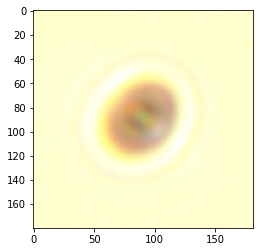

In [21]:
img = ROI_list[1]
plt.imshow(img)

In [28]:
#first create a list of all crops of an image. To have a minimum amount of bias, the cropping algorithm starts
#once from the top left and once from the bottom right (and revert these, augmenting implicitely the data)
def crop(img,size=256,stride=128):
    w,h,c = img.shape
    n_hori = int((w-size)/stride)
    n_vert = int((h-size)/stride)
    if n_hori > 0 and n_vert > 0:
        n_half = n_hori*n_vert
        crops = np.zeros((size,size,c,2*n_half),dtype = np.uint8)
        for i in range(n_hori):
            for j in range(n_vert):
                crops[:,:,:,i+n_hori*j] =      img[i*stride:i*stride+size,
                                                   j*stride:j*stride+size,:]
                crops[:,:,:,n_half+i+n_hori*j]=img[w-i*stride-1:w-(i*stride+size)-1:-1,
                                                   h-j*stride-1:h-(j*stride+size)-1:-1,:]
        return crops
    else:
        return np.zeros((size,size,c,0),dtype=np.uint8)

In [29]:
crop(img)

array([], shape=(256, 256, 3, 0), dtype=uint8)

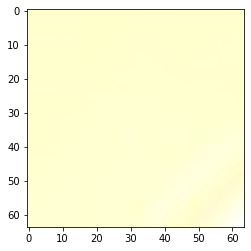

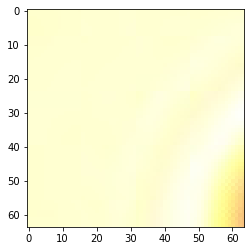

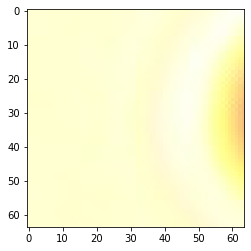

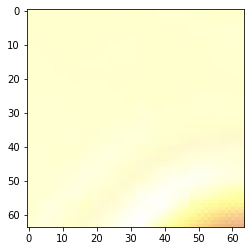

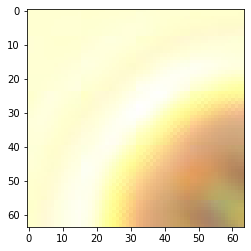

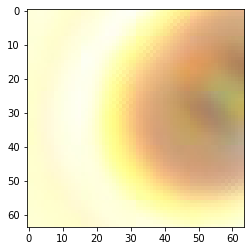

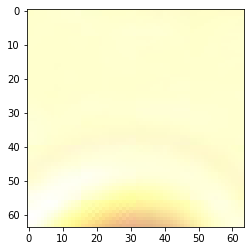

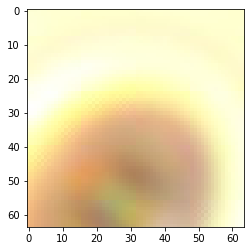

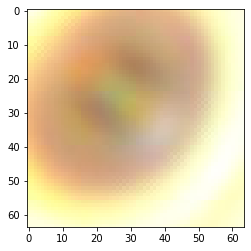

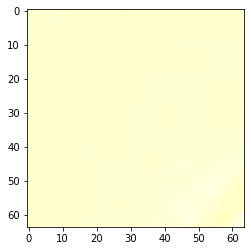

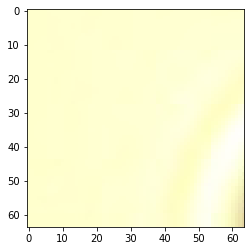

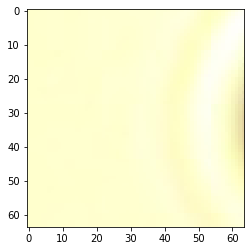

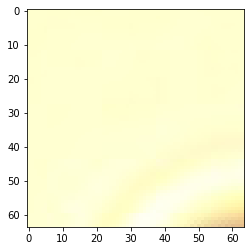

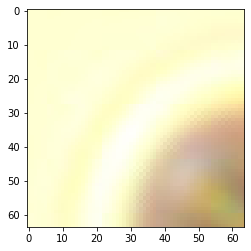

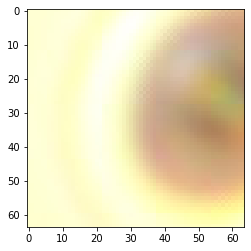

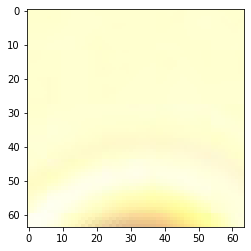

In [30]:
for i in range(16):
    plt.imshow(crop(img,size =64,stride=32)[:,:,:,i])
    plt.show()

In [31]:
def filter_crops(crops,min_diff=100,perclow=1,perchigh=99):
    f_crops = []
    for idx in range(crops.shape[-1]):
        crop = crops[:,:,:,idx]
        pl = np.percentile(crop,perclow)
        ph = np.percentile(crop,perchigh)
        if ph-pl > min_diff:
            f_crops.append(crop)
    return f_crops

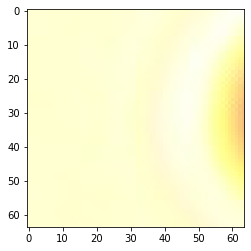

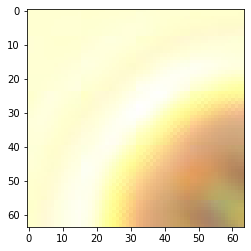

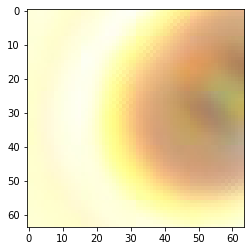

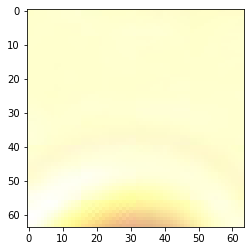

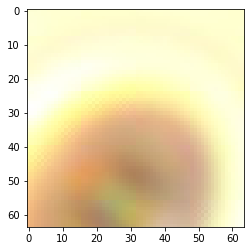

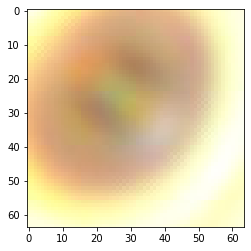

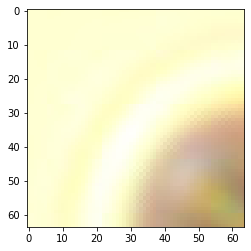

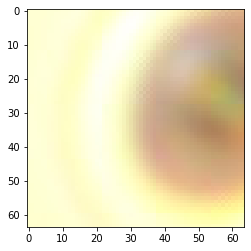

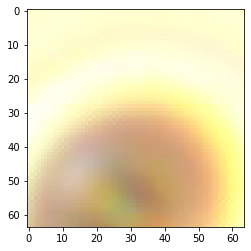

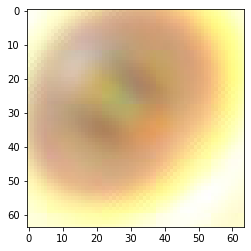

In [33]:
filtered_c = filter_crops(crop(img,size = 64,stride=32),min_diff = 100)
for i in range(len(filtered_c)):
    plt.imshow(filtered_c[i])
    plt.show()

In [34]:
#build a list with all crops from all images
size = 64
stride = 32
colors = 3

crops_usefull = []
for i,img in enumerate(ROI_list):
    if i%10==0:
        print("processing ROI "+str(i)+"/"+str(len(ROI_list)),end = '\r')
    crops = crop(img,size = size, stride = stride)
    if crops.shape[-1]==0:
        continue
    f_crops = filter_crops(crops)
    crops_usefull+=f_crops
print("processing over                              ")

KeyboardInterrupt: 

In [35]:
print(len(crops_usefull))

463085


In [ ]:
ROI_list = []

In [37]:
#save and export these usefull crops
save_file = 'crops_64_1.pickle'

with open(os.path.join(pickle_path,save_file), 'wb') as f:
    pickle.dump(crops_usefull[0:10000], f)

In [17]:
crops_usefull = []